# Постановка задачи
* Есть набор из хостов 125т
* По ним заскрейплено содержимое (HTML)
* Есть медленный парсер similarweb, он обошел всего 10т
* Нужно приоритизировать сбор урлов так, чтобы достать самые интересные урлы - первыми

In [1]:
column = 'title'

In [2]:
!ls -lh

total 18M
drwxrwxr-x 4 morph morph 4.0K Mar  4 08:39 catboost_info
-rw-rw-r-- 1 morph morph  15M Mar  4 08:23 parsed3.parquet
-rw-rw-r-- 1 morph morph 2.0M Mar  4 12:18 prioritized.parquet
-rw-rw-r-- 1 morph morph  34K Mar  4 12:20 PyPattaya meetup - ML.ipynb
-rw-rw-r-- 1 morph morph 253K Mar  4 08:22 similar_web_data_10k.parquet.gzip


In [3]:
import pandas as pd

parsed_hosts = pd.read_parquet('parsed3.parquet')
parsed_hosts = parsed_hosts.drop_duplicates('url_extended')
parsed_hosts.sample(3)

,url_extended,description,title
index,,,
50039,leninmemorial.ru,Ленинский мемориал. Ульяновск,Ленинский мемориал - официальный сайт
57712,splits.o-stuff.net,Добро пожаловать в Библиотеку Сплитов соревнов...,Библиотека спортивных достижений
11788,saratovturizm.ru,None,None


In [4]:
parsed_hosts.shape

(125130, 3)

In [5]:
similar_web = pd.read_parquet('similar_web_data_10k.parquet.gzip')
similar_web.sample(3)

,url_host,female,male,top_1_interest,top_2_interest,top_3_interest,top_4_interest,top_5_interest,18-24,25-34,35-44,45-54,55-64,65+
987,kostroma.sadsad.su,NaN,NaN,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
4511,icqinfo.ru,NaN,NaN,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
4533,fssp.gov.ru,52.26,47.74,News & Media Publishers,Legal,Computers Electronics and Technology - Other,Government,Financial Planning and Management,10.16,35.76,24.46,16.93,9.38,3.3


In [6]:
similar_web.shape

(10240, 14)

## Выделим интересные хосты
* Те, по которым есть информация
* Те, где распределение пользователей по категориям отклоняются от среднего

In [7]:
columns = ['female', 'male', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
mean_values = similar_web[columns].mean(axis=0)
mean_values

female    47.423213
male      52.576787
18-24     16.627423
25-34     34.052680
35-44     19.518149
45-54     14.669178
55-64     10.357063
65+        4.775590
dtype: float64

In [8]:
interest = (
    similar_web['male'].fillna(52.576787) 
    + similar_web['45-54'].fillna(14.669178)
)

In [9]:
# interest = (similar_web[columns] - mean_values).abs().fillna(0).sum(axis=1)
interest.sample(10)

6977    67.245965
6683    67.245965
2497    67.245965
1681    68.430000
2233    66.300000
3060    53.390000
1178    69.470000
2294    67.245965
2427    84.170000
5286    67.245965
dtype: float64

In [10]:
interest = pd.DataFrame(interest, columns=['interest'])

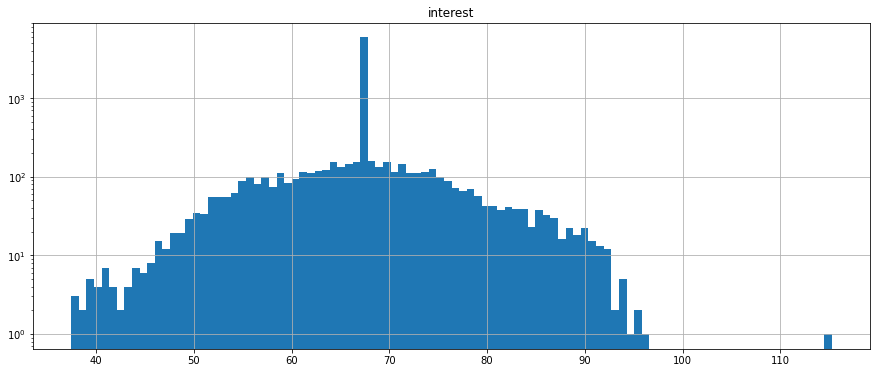

In [11]:
_ = interest.hist(bins=100, figsize=(15, 6), log=True)

In [12]:
interest = pd.concat([
    similar_web['url_host'],
    interest
], axis=1)
interest

,url_host,interest
0,pogoda.tourister.ru,67.245965
1,av.by,76.740000
2,onlinemultfilmy.ru,62.040000
3,moe.kursk.ru,67.245965
4,my.gkh.ru,67.245965
...,...,...
7734,prodoctorov.ru,54.700000
7735,lkfl2.nalog.ru,67.245965
7736,voyagespb.ru,67.245965
7737,pushkinskijdom.ru,59.840000


In [13]:
parsed_hosts[column] = parsed_hosts[column].fillna('')

In [14]:
interest = interest.merge(parsed_hosts, left_on='url_host', right_on='url_extended')[['url_host', column, 'interest']]

## ML магия )

### Признаки - слова в заголовке сайта

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=3)
features = vectorizer.fit_transform(interest[column].fillna(''))
features

<8302x2814 sparse matrix of type '<class 'numpy.int64'>'
	with 35505 stored elements in Compressed Sparse Row format>

### catboost - надежная и неприхотливая модель для ML

In [16]:
from catboost import CatBoostRegressor, Pool

In [17]:
train = Pool(features, interest['interest'])

In [18]:
model = CatBoostRegressor(metric_period=50)
model.fit(train)

Learning rate set to 0.057202
0:	learn: 6.8997030	total: 51.1ms	remaining: 51s
50:	learn: 6.6224596	total: 264ms	remaining: 4.91s
100:	learn: 6.4905047	total: 475ms	remaining: 4.23s
150:	learn: 6.3829566	total: 681ms	remaining: 3.83s
200:	learn: 6.2781339	total: 873ms	remaining: 3.47s
250:	learn: 6.1858843	total: 1.08s	remaining: 3.21s
300:	learn: 6.1090101	total: 1.29s	remaining: 2.99s
350:	learn: 6.0443777	total: 1.49s	remaining: 2.75s
400:	learn: 5.9857603	total: 1.68s	remaining: 2.51s
450:	learn: 5.9288812	total: 1.87s	remaining: 2.27s
500:	learn: 5.8814058	total: 2.08s	remaining: 2.07s
550:	learn: 5.8334663	total: 2.27s	remaining: 1.85s
600:	learn: 5.7890037	total: 2.48s	remaining: 1.65s
650:	learn: 5.7495849	total: 2.67s	remaining: 1.43s
700:	learn: 5.7088494	total: 2.86s	remaining: 1.22s
750:	learn: 5.6722412	total: 3.05s	remaining: 1.01s
800:	learn: 5.6400057	total: 3.25s	remaining: 809ms
850:	learn: 5.6117135	total: 3.46s	remaining: 607ms
900:	learn: 5.5816627	total: 3.68s	rem

## Применим модель на остальные сайты

In [19]:
features_test = vectorizer.transform(parsed_hosts[column])

In [20]:
features_test

<125130x2814 sparse matrix of type '<class 'numpy.int64'>'
	with 363319 stored elements in Compressed Sparse Row format>

In [21]:
test = Pool(features_test)

In [22]:
parsed_hosts['interest'] = model.predict(test)

In [23]:
mask_scraped_similar_web = parsed_hosts['url_extended'].isin(interest['url_host'])
prioritized_hosts = parsed_hosts[~mask_scraped_similar_web].sort_values('interest', ascending=False)

In [24]:
prioritized_hosts[['url_extended']].to_parquet('prioritized.parquet')

In [25]:
prioritized_hosts['url_extended'].head(50)

index
113121              full-game.ru
96670            avto-pitstop.ru
98020           fanatgta.ucoz.ru
61725              audi-forum.ru
120204                  nibbl.ru
116382                cheerss.ru
81886                  allgaz.ru
66536                   game4.ru
87773           make-a-choice.ru
33734                i-fix-it.ru
103805               gidplay.net
82614           wotinspector.com
60988              toyotainfo.ru
124316          prokarbyrator.ru
82363            cloudgame.press
121211               xraycars.ru
126636                 vwclub.su
100906                  onexp.ru
105583               ninja-it.ru
122539              under-car.ru
61051          remont-avtovaz.ru
94157         anime-igri.ucoz.ru
58761                megamozg.su
118321                 kodbox.ru
114714                vebtech.ru
115176              xtgamers.com
94807          avtoliteratura.ru
89577               genapilot.ru
73111                 izhstar.ru
73659          noob-game.ucoz.ru
1023

In [37]:
vocabulary = [
    word
    for word, _ in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])
]
vocabulary[:10]

['000', '10', '100', '1000', '102', '1080', '1080p', '11', '14', '16']

In [40]:
sorted(zip(model.get_feature_importance(), vocabulary), reverse=True)[:50]

[(5.3697480969013975, 'автомобилей'),
 (2.757021875652325, 'авто'),
 (2.6100041724756498, 'новости'),
 (2.290896895147138, 'учителей'),
 (2.1982111246880316, 'рецепты'),
 (1.6553503266227039, 'онлайн'),
 (1.428150931721515, 'автомобили'),
 (1.3205051906203424, 'родителей'),
 (1.2554530726484636, 'сайт'),
 (1.2063064965725507, 'запчастей'),
 (1.1974210256932765, 'автомобильный'),
 (1.1703745356328992, 'аниме'),
 (1.1637124137798622, 'тесты'),
 (1.1300314624373882, 'обзоры'),
 (1.0050074021814819, 'ремонт'),
 (0.9648492623345956, 'журнал'),
 (0.9538079927741244, 'of'),
 (0.9070264425067347, 'android'),
 (0.8609211001997451, 'стихи'),
 (0.821877357754078, 'форум'),
 (0.8176739881616051, 'образовательный'),
 (0.813934182109482, 'электроники'),
 (0.7025737689266764, 'советы'),
 (0.6776643613651473, 'бухгалтера'),
 (0.6602001929909579, 'беларуси'),
 (0.6559284391444804, 'игровой'),
 (0.6476899010419231, 'kz'),
 (0.6439367506577857, 'домашние'),
 (0.625467161932391, 'it'),
 (0.598100613402483